In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import json
import re
import random

In [2]:
# Read the dataset
df = pd.read_excel('./dataset.xlsx', sheet_name='main')
df2 = pd.read_excel('./dataset.xlsx', sheet_name='archive')

In [3]:
# Combining the dataset into 1D array or string
answerKey = list(df)[2::]
combinedAnswer = []
for key in answerKey:
    for answer in df[key]:
        if pd.isna(answer): break
        combinedAnswer.append(answer)
badAnswerKey = list(df2)[2::]
combinedBadAnswer = []
for key in badAnswerKey:
    for badAnswer in df2[key]:
        if pd.isna(badAnswer): break
        combinedBadAnswer.append(badAnswer)

print(f"Total Raw Answer: {len(combinedAnswer)}")
print(f"Total Raw Bad Answer: {len(combinedBadAnswer)}")

Total Raw Answer: 2720
Total Raw Bad Answer: 1065


In [4]:
# Filtering the good type of answer from both dataset
# the filter is detect a word 'saya' and a coma within 10 first sentences
goodAnswer = []
badAnswer = []
for answer in combinedAnswer:
    splitAnswer = answer.split(' ')
    sentence = ' '.join(splitAnswer[:10]).lower()
    if 'saya' in sentence and ',' in sentence:
        goodAnswer.append(sentence)
    else :
        badAnswer.append(sentence)
for answer in combinedBadAnswer:
    splitAnswer = answer.split(' ')
    sentence = ' '.join(splitAnswer[:10]).lower()
    if 'saya' in sentence and ',' in sentence:
        goodAnswer.append(sentence)
    else :
        badAnswer.append(sentence)
        
print(f"Total Good Answer: {len(goodAnswer)}")
print(f"Total Bad Answer: {len(badAnswer)}")

Total Good Answer: 1032
Total Bad Answer: 2753


In [5]:
# set a labels
labels = pd.Series(np.concatenate([np.ones(len(goodAnswer)), np.zeros(len(badAnswer))], axis=0))
print("Final Combined Labels:", len(labels))

Final Combined Labels: 3785


In [6]:
# combining the good and bad answer
combinedData = np.concatenate((goodAnswer, badAnswer))
print("Final Combined Data:", len(combinedData))

Final Combined Data: 3785


In [7]:
# shuffling the answer for good training and validation split
combined = list(zip(combinedData, labels))
random.shuffle(combined)
combined1, combined2 = zip(*combined)

In [8]:
# counting vocabulary size to avoid overfitting
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(combinedData)
vocab_size = len(vectorizer.get_feature_names_out())
print("Vocabulary Size:", vocab_size)

Vocabulary Size: 2381


In [9]:
training_size = round(len(combinedData) * 0.95)
max_length = 10
embedding_dim = 32

In [10]:
# splitting training and validation data
training_sentences = combinedData[0:training_size]
testing_sentences = combinedData[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [11]:
# converting the data into sequences and give a padding
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [12]:
# Saving training sentences data into json
word_dict = {item[0]: item[1] for item in tokenizer.word_index.items()}
with open('tokenizer_dict_struktur.json', 'w') as json_file:
    json.dump(word_dict, json_file, indent=4)

In [13]:
# Declare graph function
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])

    plt.ylim(top=1.1, bottom=0)

    plt.show()

In [14]:
# Declare the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 32)            76192     
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 76,737
Trainable params: 76,737
Non-trainable params: 0
____________________________________________________

Epoch 1/12
113/113 - 1s - loss: 0.6409 - accuracy: 0.7111 - val_loss: 0.3982 - val_accuracy: 1.0000 - 790ms/epoch - 7ms/step
Epoch 2/12
113/113 - 0s - loss: 0.5476 - accuracy: 0.7286 - val_loss: 0.2598 - val_accuracy: 0.9947 - 142ms/epoch - 1ms/step
Epoch 3/12
113/113 - 0s - loss: 0.4517 - accuracy: 0.8109 - val_loss: 0.1850 - val_accuracy: 0.9788 - 139ms/epoch - 1ms/step
Epoch 4/12
113/113 - 0s - loss: 0.3718 - accuracy: 0.8515 - val_loss: 0.1591 - val_accuracy: 0.9683 - 129ms/epoch - 1ms/step
Epoch 5/12
113/113 - 0s - loss: 0.3150 - accuracy: 0.8818 - val_loss: 0.1379 - val_accuracy: 0.9683 - 128ms/epoch - 1ms/step
Epoch 6/12
113/113 - 0s - loss: 0.2836 - accuracy: 0.8963 - val_loss: 0.1511 - val_accuracy: 0.9524 - 126ms/epoch - 1ms/step
Epoch 7/12
113/113 - 0s - loss: 0.2508 - accuracy: 0.9102 - val_loss: 0.1586 - val_accuracy: 0.9312 - 128ms/epoch - 1ms/step
Epoch 8/12
113/113 - 0s - loss: 0.2296 - accuracy: 0.9177 - val_loss: 0.1601 - val_accuracy: 0.9365 - 127ms/epoch - 1ms/step


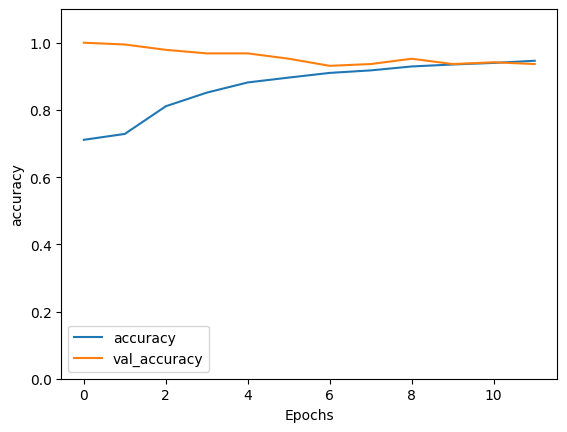

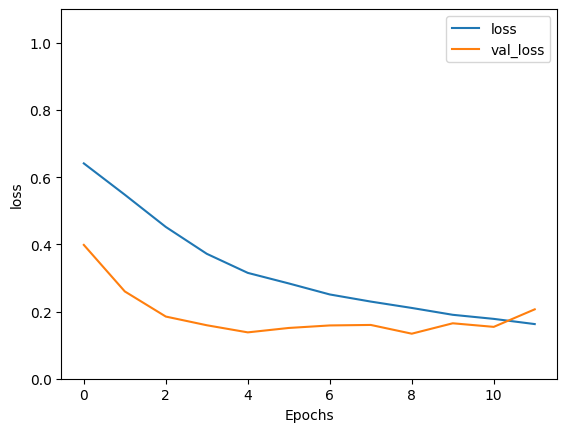

In [15]:
model.compile(loss='binary_crossentropy',optimizer=Adam(0.001),metrics=['accuracy'])
history = model.fit(training_padded, training_labels, epochs=12, validation_data=(testing_padded, testing_labels), verbose=2)
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [16]:
def predict(text, treshold=0.5):
    input_sequence = tokenizer.texts_to_sequences([text])
    padded_input = pad_sequences(input_sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    predictions = model.predict(padded_input)
    threshold = 0.5
    predicted_class = 1 if predictions[0][0] > threshold else 0
    print('Bagus' if predicted_class == 1 else 'Kurang Bagus')

In [17]:
predict("saya biasanya membuat daftar prioritas untuk menentukan tindakan yang paling mendesak.")

1/1 [==============================] - 0s 53ms/step
Kurang Bagus


In [18]:
predict("Ketika saya dihadapkan pada masalah, saya biasanya membuat daftar prioritas untuk menentukan tindakan yang paling mendesak.")

1/1 [==============================] - 0s 13ms/step
Bagus


With treshold of 0.5, the predict function will return a result 0 or 1,
0 means the sentences is bad, and 1 means the sentences is good